# An improved implementation of a high-pass filter - SOLUTION

Let's begin by exploring what was wrong with our naïve implementation. To illustrate this let's modify our example. We'll generate a similar dataset, but instead of generating our low frequency noise at regular frequencies, we will generate them at random. This means that they may live in-between the frequency bins of our discrete Fourier transform, and we will see the effect that has.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

In [2]:
# Choose data length and sampling rate
omega = 1. * (2*np.pi)
data_length = 8
sample_rate = 16
sample_points = int(data_length * sample_rate)

times = np.arange(sample_points) / sample_rate
frequencies = np.arange(sample_points) * (sample_rate/sample_points)

np.random.seed(0)
data_time_domain = np.zeros(sample_points)
# Add low frequency noise: No components above 1Hz
for i in range(1,(data_length) + 1):
    # We generate a random number between 0 and 1 for the frequency,
    # This means it won't line up perfectly with the
    omega = np.random.uniform() * (2*np.pi)
    # randomly set the phase, so that it isn't all in the
    # imaginary frequency component!
    phase = np.random.random() * (2*np.pi)
    data_time_domain += 100 * np.sin(times * omega + phase)

# Add in a single 4Hz sine wave - random phase again
omega = 4. * (2*np.pi)
phase = np.random.random() * 2 * np.pi
signal = np.cos(times * omega + phase)
data_time_domain += signal

## Exercise

As in part 1, plot this data in the Fourier domain, and transform back to the time domain.

Then, as before, transform the data to the Fourier domain, perform a basic high-pass filter, as we did previously, and plot the data again.

Can you see the sine wave on any of this data? (The answer now should be "no")

In [ ]:
# Bring in FT functions from previous work

def compute_fourier_transform(data_time_domain):
    return 


def compute_inverse_fourier_transform(data_frequency_domain):
    return

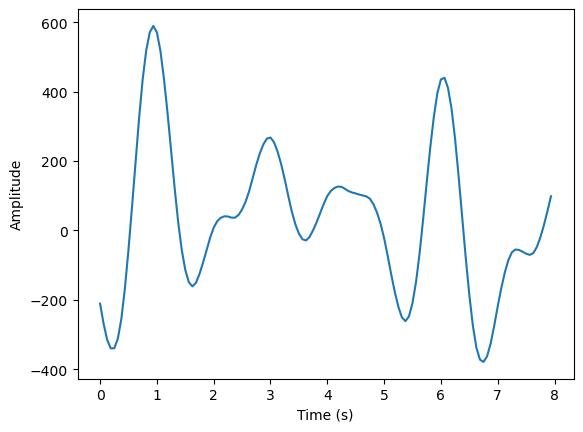

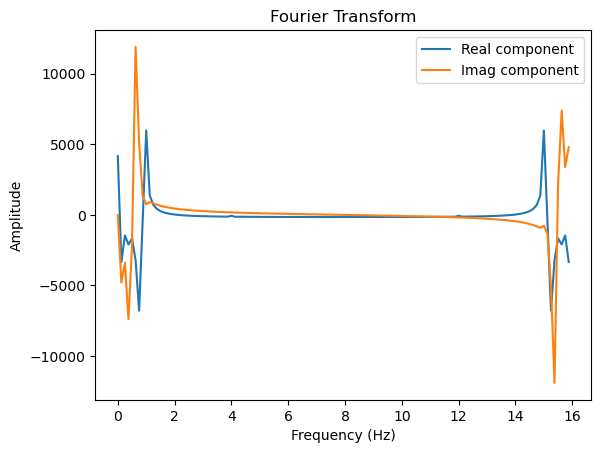

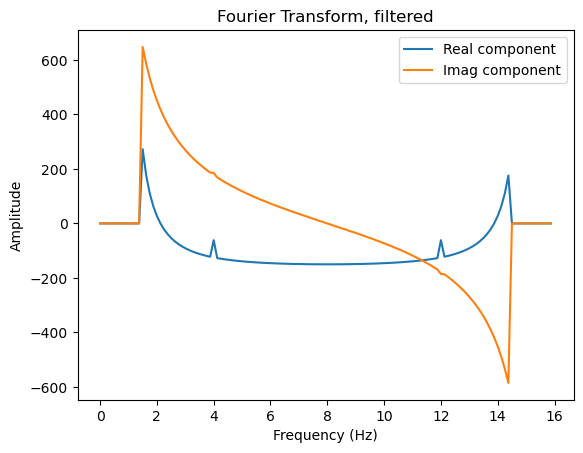

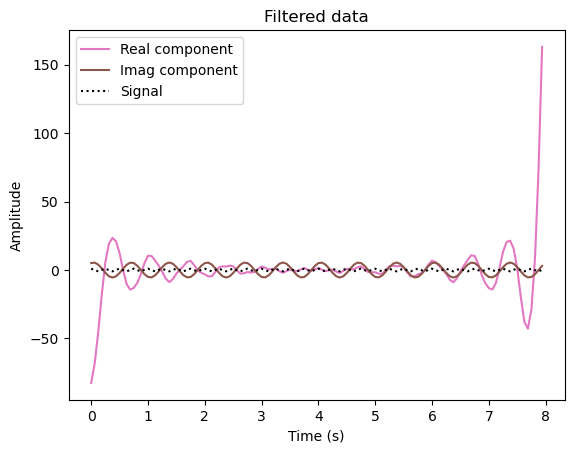

## Huh?!

We did the same process as in the previous step, where we *did* manage to extract the signal. So what's the difference here? Why can we not recover the signal in this case?

To answer this we need to think about the theory of Fourier transforms: As we said previously, any discrete time series can be represented as a frequency series by a Fourier transform. However, **this assumes that the data is cyclical**, this means that the data should repeat itself. So in the time domain, we consider that when we reach the end of the dataset we start again at the beginning.

This was not a problem in our first example, because we generated the noise such that the end was smoothly connected to the start. We can see this by repeating the dataset and examining the "join":

In [5]:
# Generate the data so that the noise is all perfectly cyclical
np.random.seed(0)
data_time_domain_clean = np.zeros(sample_points)
# Add low frequency noise: No components above 1Hz
for i in range(1,(data_length+1)):
    omega = i / data_length * (2*np.pi)
    phase = np.random.random() * (2*np.pi)
    data_time_domain_clean += 100*np.sin(times * omega + phase)

# Add in a single 4Hz sine wave
omega = 4. * (2*np.pi)
data_time_domain_clean += np.cos(times * omega)

times_TWICE = np.append(times, times + data_length)

Text(0, 0.5, 'Amplitude')

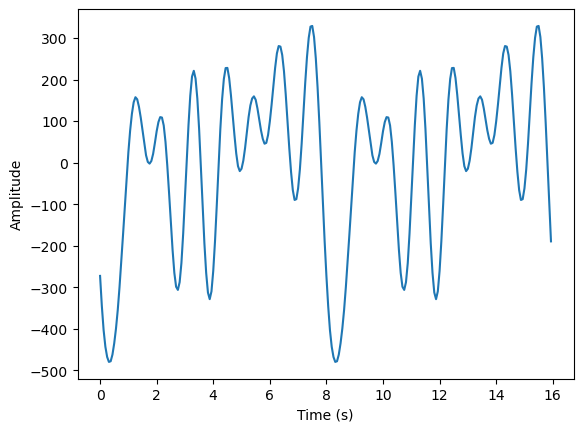

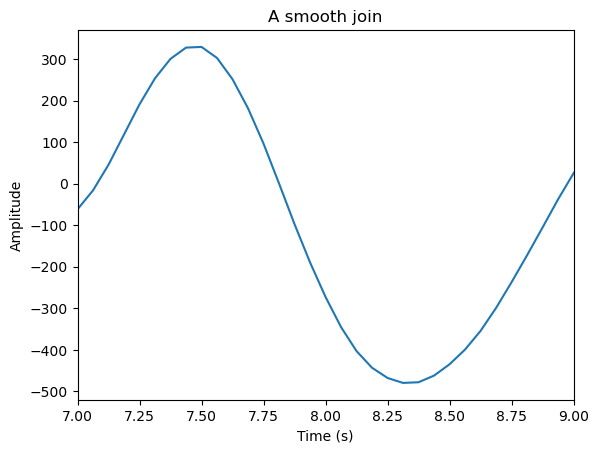

In [ ]:
# Here I am talking the data, and then *repeating* it; the first
# half is identical to the second half
plt.plot(times_TWICE, np.append(data_time_domain_clean, data_time_domain_clean))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
plt.title("A smooth join")
plt.plot(times_TWICE, np.append(data_time_domain_clean, data_time_domain_clean))
plt.xlabel('Time (s)')
plt.xlim([data_length-1,data_length+1])
plt.ylabel('Amplitude')


In this case we can see that the data is repeating and the "join" is smooth. In contrast, for our new dataset:

Text(0, 0.5, 'Amplitude')

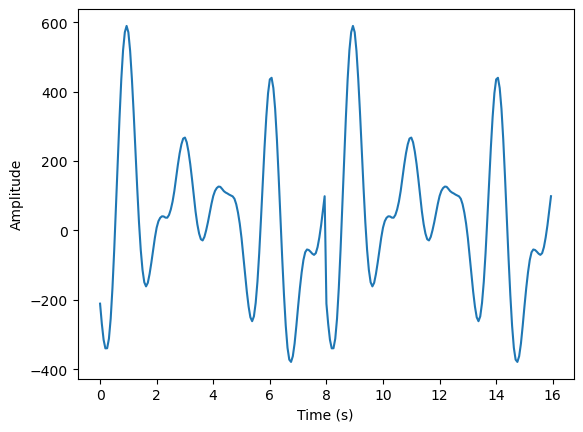

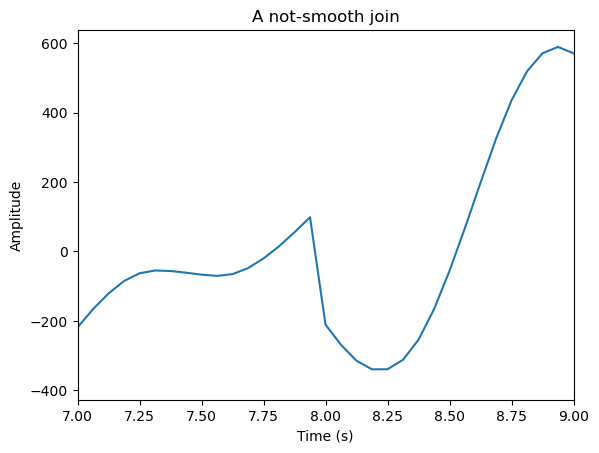

In [7]:
times_TWICE = np.append(times, times + data_length)

plt.plot(times_TWICE, np.append(data_time_domain, data_time_domain))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.figure()
plt.title("A not-smooth join")
plt.plot(times_TWICE, np.append(data_time_domain, data_time_domain))
plt.xlabel('Time (s)')
plt.xlim([data_length-1,data_length+1])
plt.ylabel('Amplitude')


We can see above that the transition here is *not* smooth (run the code with a different seed and generate the plot again if this is not so clear). Joining these two datasets introduces a delta-function in the data. As we saw earlier a discontinuity, or delta-function, produces broad frequency content in the Fourier transform. The high-pass filter removes a lot of this content, but cannot remove the content above 1Hz.

Unfortunately, most real examples will look like the case above, and not the simple case.

So how do we deal with this? In short, we have to remove this discontinuity!

Let's first deal with the case that I am *only* concerned about my 8s data set for now. If I want to get rid of the delta-function. I can "window" the data. This means that data at the edges is set to 0, by multiplying by some sort of smooth curve between 0 and 1 (called a window function). Let's show a quick example of this and then explain a bit more:

Text(0, 0.5, 'Amplitude')

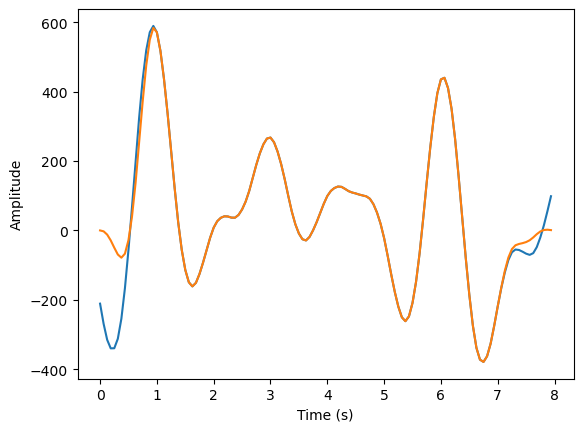

In [8]:
# IMPORTANT TO USE COPY HERE SO WE DON'T EDIT BOTH ARRAYS!!
data_time_domain_windowed = np.copy(data_time_domain)
# We are going to apply the window to the first and last 1/8th of the data

window = np.ones_like(data_time_domain_windowed)
# apply the window to the first 1/8th of the data
npoints = int(len(window) / 8)
window[:npoints] = 0.5 - 0.5 * np.cos(times[:npoints] * np.pi * data_length / 8)
window[-npoints:] = 0.5 + 0.5 * np.cos(times[:npoints] * np.pi * data_length / 8)

data_time_domain_windowed = (
    data_time_domain_windowed * window
)
    
# NOTE: times[:npoints] goes from 0 to (almost) 1, so the factor on the right above here is a cosine
# transitioning from 0 to 1 (or vice versa)

plt.plot(times, data_time_domain)
plt.plot(times, data_time_domain_windowed)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')


What we have done here is taper the data to 0 at both ends. This will remove some actual content from the data, but will ensure that the data meets (mostly) smoothly at the ends (the second derivative is not continuous at this point, so it is not truly smooth with the window I chose!) We can, however, see that this data joins up much better in the middle.


## Exercise

Show that the data is now smooth if we join the start of the data to the end (by making the same plot as we made above over 16 seconds). Then Fourier transform this data again, and see if we can see the signal now. Also use our basic high-pass filter on this windowed data and see if we can extract the signal in the time domain.
Plot the signal we are trying to extract to see how close we are now

HINT: Try removing data up to 3Hz to improve ability to extract the signal!

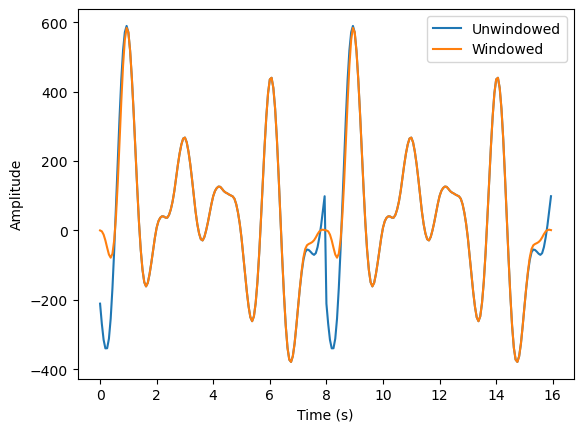

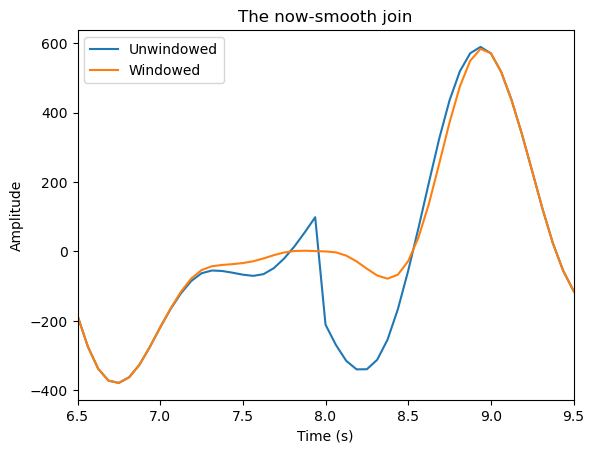

In [ ]:
# Show that the data is now smooth at the edges


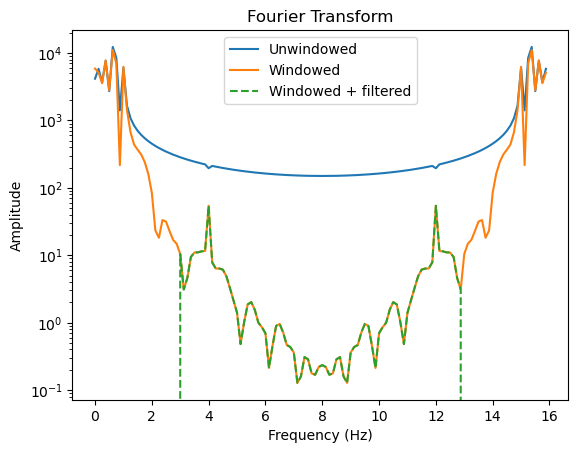

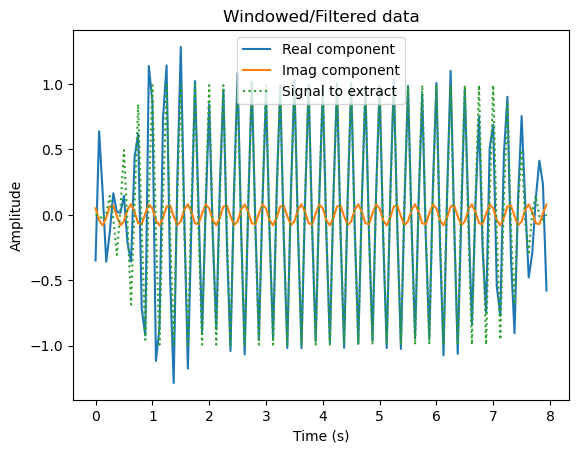

In [ ]:
# Same as before, let's do a high-pass filter. 
# We'll remove all content below 3Hz 
# (and the corresponding high-frequency values)

# plot the unwindowed, windowed and windowed+filtered data
# in the frequency domain

# Convert the windowed+filtered data back into the time domain


# Plot what we have recovered after the high-pass filter
# in the time domain

# Compare this to what the extracted cosine wave should be

In this case, we should be able to see a spike in the Fourier domain data at 4Hz, but the windowing itself introduces some noise at all frequencies, and we do not perfectly recover the sine wave. But it is much better than the un-windowed case.

This is the general real-world example! This could be improved by (for example) using a different windowing function. For example we could have windowed more data, smoothing out the noise introduced by the window, but removing more of the data. There's also a variety of possible ways to smoothly bring data to 0:

https://en.wikipedia.org/wiki/Window_function

Some of which may perform better than our (Tukey) window in this instance.


## Optional Exercise

Investigate if you can better recover the signal in this dataset by using different windowing filters, or different filter lengths.

In [11]:
# No solution will be provided here